In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [17]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [19]:
# load the dataset
dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [38]:
dataframe

,Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


In [24]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [25]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [26]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [27]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [28]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [29]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


/home/mjlange20/anaconda3/envs/binary/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 - 1s - 10ms/step - loss: 0.0591
Epoch 2/100
94/94 - 0s - 1ms/step - loss: 0.0298
Epoch 3/100
94/94 - 0s - 870us/step - loss: 0.0217
Epoch 4/100
94/94 - 0s - 829us/step - loss: 0.0195
Epoch 5/100
94/94 - 0s - 866us/step - loss: 0.0182
Epoch 6/100
94/94 - 0s - 840us/step - loss: 0.0171
Epoch 7/100
94/94 - 0s - 834us/step - loss: 0.0160
Epoch 8/100
94/94 - 0s - 827us/step - loss: 0.0150
Epoch 9/100
94/94 - 0s - 845us/step - loss: 0.0139
Epoch 10/100
94/94 - 0s - 806us/step - loss: 0.0129
Epoch 11/100
94/94 - 0s - 827us/step - loss: 0.0119
Epoch 12/100
94/94 - 0s - 944us/step - loss: 0.0109
Epoch 13/100
94/94 - 0s - 846us/step - loss: 0.0099
Epoch 14/100
94/94 - 0s - 806us/step - loss: 0.0089
Epoch 15/100
94/94 - 0s - 814us/step - loss: 0.0080
Epoch 16/100
94/94 - 0s - 829us/step - loss: 0.0072
Epoch 17/100
94/94 - 0s - 822us/step - loss: 0.0064
Epoch 18/100
94/94 - 0s - 802us/step - loss: 0.0056
Epoch 19/100
94/94 - 0s - 871us/step - loss: 0.0049
Epoch 20/100
94/94 - 0s - 813us/step

In [30]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Score: 22.89 RMSE
Test Score: 48.57 RMSE


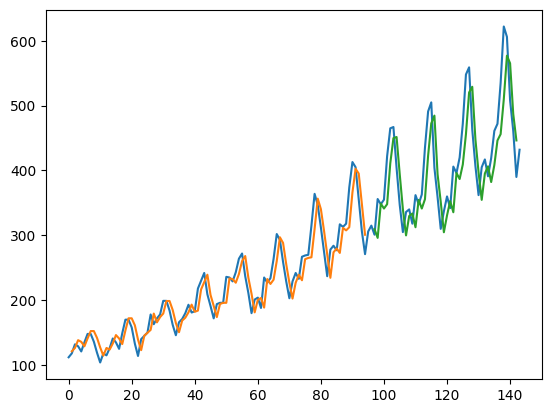

In [36]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()